In [1]:
from keras.layers import Lambda, Input, Dense
from keras.models import Model
#from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K
from keras import metrics

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os
import datetime as dt
import time
import glob
from IPython import display
import tensorflow as tf
tfe = tf.contrib.eager
tf.enable_eager_execution()



Using TensorFlow backend.


In [2]:
# def plot_autoencoder_outputs(encoder, n, dims):
#     #decoded_imgs = enconder.predict(x_test)
#     x_test_encoded = vae.predict(x_test, batch_size = batch_size)
#     # number of example digits to show
#     n = 5
#     plt.figure(figsize=(20, 9))
#     for i in range(n):
#         # plot original image
#         ax = plt.subplot(2, n, i + 1)
#         plt.imshow(x_test[i].reshape(*dims))
#         #plt.gray()
#         ax.get_xaxis().set_visible(False)
#         ax.get_yaxis().set_visible(False)
#         if i == n/2:
#             ax.set_title('Original Images')

#         # plot reconstruction 
#         ax = plt.subplot(2, n, i + 1 + n)
#         plt.imshow(x_test_encoded[i].reshape(*dims))
#         #plt.gray()
#         ax.get_xaxis().set_visible(False)
#         ax.get_yaxis().set_visible(False)
#         if i == n/2:
#             ax.set_title('Reconstructed Images')
#     plt.show()

# def plot_loss(history):
#     historydf = pd.DataFrame(history.history, index=history.epoch)
#     plt.figure(figsize=(8, 6))
#     historydf.plot(ylim=(0, historydf.values.max()))
#     plt.title('Loss: %.3f' % history.history['loss'][-1])
    
# def plot_compare_histories(history_list, name_list, plot_accuracy=True):
#     dflist = []
#     min_epoch = len(history_list[0].epoch)
#     losses = []
#     for history in history_list:
#         h = {key: val for key, val in history.history.items() if not key.startswith('val_')}
#         dflist.append(pd.DataFrame(h, index=history.epoch))
#         min_epoch = min(min_epoch, len(history.epoch))
#         losses.append(h['loss'][-1])

#     historydf = pd.concat(dflist, axis=1)

#     metrics = dflist[0].columns
#     idx = pd.MultiIndex.from_product([name_list, metrics], names=['model', 'metric'])
#     historydf.columns = idx
    
#     plt.figure(figsize=(6, 8))

#     ax = plt.subplot(211)
#     historydf.xs('loss', axis=1, level='metric').plot(ylim=(0,1), ax=ax)
#     plt.title("Training Loss: " + ' vs '.join([str(round(x, 3)) for x in losses]))
    
#     if plot_accuracy:
#         ax = plt.subplot(212)
#         historydf.xs('acc', axis=1, level='metric').plot(ylim=(0,1), ax=ax)
#         plt.title("Accuracy")
#         plt.xlabel("Epochs")
    
#     plt.xlim(0, min_epoch-1)
#     plt.tight_layout()

In [2]:
# Import whole N-MNIST Dataset
def load_NMNIST(path):
    """
    """
    xs_train = []
    ys_train = []
    xs_test = []
    ys_test = []

    for class_index in range(0, 10):
        for (root, dirs, dat_files) in os.walk('{0}/n_Train_3/{1}'.format(path, str(class_index))):
            for file in dat_files:
                single_X = np.fromfile('{0}/n_Train_3/{1}/{2}'.format(path, str(class_index), file), dtype=np.int32)
                xs_train.append(single_X)
                ys_train.append(class_index)

        for (root, dirs, dat_files) in os.walk('{0}/n_Test_3/{1}'.format(path, str(class_index))):
            for file in dat_files:
                xs_test.append(np.fromfile('{0}/n_Test_3/{1}/{2}'.format(path, str(class_index), file), dtype=np.int32))
                ys_test.append(class_index)

    Xtr = np.array(xs_train)
    Xtr_reshaped = Xtr.reshape(60000, 34, 34, 2)
    Ytr = np.array(ys_train)
    Xte = np.array(xs_test)
    Xte_reshaped = Xte.reshape(10000, 34, 34, 2)
    Yte = np.array(ys_test)

    return Xtr_reshaped, Ytr, Xte_reshaped, Yte

In [3]:
dataset_class_path = '/Users/ching/Desktop/Project/autoencoder_nmnist/NMNIST/datasets'
x_train_1, y_train, x_test_1, y_test = load_NMNIST(dataset_class_path)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', x_train_1.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', x_test_1.shape)
print('Test labels shape: ', y_test.shape)

# 34 x 34 x 2

Training data shape:  (60000, 34, 34, 2)
Training labels shape:  (60000,)
Test data shape:  (10000, 34, 34, 2)
Test labels shape:  (10000,)


In [4]:
# Flatten the dataset from range -1 to 1. Since the maxima and minima lies btw 15 so we divide it by 15.
x_train = (x_train_1.astype('float32'))
x_test = (x_test_1.astype('float32'))

In [5]:
np.shape(x_test)

(10000, 34, 34, 2)

In [6]:
x_train[x_train!=0]+=30
x_test[x_test!=0]+=30
#print(x_train.shape)
#print(max(x_train[0])) #Test the maximum value after flatten

In [7]:
#x_train = x_train/45
x_train[:] = [x / 45 for x in x_train]
#x_test = x_test/45
x_test[:] = [x / 45 for x in x_test]

In [8]:
# x_train[x_train>0]=1
# x_train[x_train<0]=-1
# x_test[x_test>0]=1
# x_test[x_test<0]=-1
# #print(x_train.shape)
# #print(max(x_train[0])) #Test the maximum value after flatten

In [9]:
TRAIN_BUF = 60000
BATCH_SIZE = 100

TEST_BUF = 10000

In [10]:
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(TRAIN_BUF).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices(x_test).shuffle(TEST_BUF).batch(BATCH_SIZE)

In [17]:
class CVAE(tf.keras.Model):
    def __init__(self, latent_dim):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.inference_net = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(34, 34, 2)),
                
                tf.keras.layers.Conv2D(
                    filters=32, kernel_size=(3, 3), strides=(2, 2), activation=tf.nn.relu),
                
                tf.keras.layers.Conv2D(
                    filters=64, kernel_size=(3, 3), strides=(2, 2), activation=tf.nn.relu),
                
                tf.keras.layers.Flatten(),
                
                # No activation
                tf.keras.layers.Dense(latent_dim + latent_dim),
            ]
        )
        
        self.generative_net = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
                
                tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
                
                tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
                
                tf.keras.layers.Conv2DTranspose(
                    filters=64,
                    kernel_size=(3, 3),
                    strides=(2, 2),
                    padding="SAME",
                    activation=tf.nn.relu),
                
                tf.keras.layers.Conv2DTranspose(
                    filters=32,
                    kernel_size=(3, 3),
                    strides=(2, 2),
                    padding="SAME",
                    activation=tf.nn.relu),
                
                # No activation
                tf.keras.layers.Conv2DTranspose(
                    filters=1, kernel_size=(3, 3), strides=(2, 2), padding="SAME"),
            ]
        )
        
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random_normal(shape=(100, self.latent_dim))
            return self.decode(eps, apply_sigmoid=True)

    def encode(self, x):
        mean, logvar = tf.split(self.inference_net(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random_normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z, apply_sigmoid=False):
        logits = self.generative_net(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        
        return logits

In [18]:
def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.log(2. * np.pi)
    return tf.reduce_sum(
        -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
        axis=raxis)

def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)
    
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)

def compute_gradients(model, x):
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)
    return tape.gradient(loss, model.trainable_variables), loss

optimizer = tf.train.AdamOptimizer(1e-4)
def apply_gradients(optimizer, gradients, variables, global_step=None):
    optimizer.apply_gradients(zip(gradients, variables), global_step=global_step)

In [19]:
epochs = 100
latent_dim = 50
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random_normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

In [28]:
model.fit((train_dataset, train_dataset), epochs=epochs, batch_size=BATCH_SIZE, steps_per_epoch = 60000)


ValueError: Please provide as model inputs either a single array or a list of arrays. You passed: x=(<BatchDataset shapes: (?, 34, 34, 2), types: tf.float32>, <BatchDataset shapes: (?, 34, 34, 2), types: tf.float32>)

In [10]:
epsilon_std=0.01

# z = z_mean + sqrt(var)*eps
#returns random value of z with the gives mean and variance
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.0, stddev=epsilon_std)
    return z_mean + K.exp(z_log_sigma/2) * epsilon

In [11]:
# network parameters
#batch_size - number of training examples 
#that are used at the same time to train the NN
#latent_dim - defines the dimentionality of the latent space
#2D latent space in this case
input_shape = (2312, )
intermediate_dim_1 = 64
intermediate_dim_2 = 32
intermediate_dim_3 = 16
intermediate_dim_4 = 8
intermediate_dim_5 = 8
batch_size = 80
latent_dim = 2
epochs = 50

In [12]:
# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim_1, activation='relu')(inputs)
x = Dense(intermediate_dim_2, activation='relu')(x)
x = Dense(intermediate_dim_3, activation='relu')(x)
#x = Dense(intermediate_dim_4, activation='tanh')(x)
#x = Dense(intermediate_dim_5, activation='tanh')(x)
# x = Dense(intermediate_dim_2, activation='relu')(inputs)
# x = Dense(intermediate_dim_3, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

In [13]:
# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 2312)         0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 64)           148032      encoder_input[0][0]              
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 32)           2080        dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 16)           528         dense_2[0][0]                    
__________________________________________________________________________________________________
z_mean (De

In [14]:
# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
#x = Dense(intermediate_dim_5, activation='tanh')(latent_inputs)
#x = Dense(intermediate_dim_4, activation='tanh')(latent_inputs)
x = Dense(intermediate_dim_3, activation='relu')(latent_inputs)
x = Dense(intermediate_dim_2, activation='relu')(x)
x = Dense(intermediate_dim_1, activation='relu')(x)
# x = Dense(intermediate_dim_3, activation='relu')(latent_inputs)
# x = Dense(intermediate_dim_2, activation='relu')(x)
outputs = Dense(2312, activation='sigmoid')(x)

In [15]:
# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary() 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      (None, 2)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                48        
_________________________________________________________________
dense_5 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_6 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_7 (Dense)              (None, 2312)              150280    
Total params: 152,984
Trainable params: 152,984
Non-trainable params: 0
_________________________________________________________________


In [16]:
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')
vae_test=Model(inputs, outputs, name='vae_test')

In [17]:
# Compute VAE loss
xent_loss = 2312 * binary_crossentropy(inputs, outputs)
#xent_loss = binary_crossentropy(inputs, outputs)

kl_loss = -0.5*K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss =abs(K.mean(xent_loss + kl_loss))

vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae_test.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])
vae.summary()
vae_test.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 2312)              0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 150708    
_________________________________________________________________
decoder (Model)              (None, 2312)              152984    
Total params: 303,692
Trainable params: 303,692
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 2312)              0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 150708    
_________________________________________________________________
deco

In [18]:
import datetime as dt

In [19]:
start_time = dt.datetime.now()
print('Start learning at {}'.format(str(start_time)))

vae.fit(x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_split= 0.2)

end_time = dt.datetime.now() 
print('Stop learning {}'.format(str(end_time)))
elapsed_time= end_time - start_time
print('Elapsed learning {}'.format(str(elapsed_time)))

Start learning at 2019-01-23 13:53:30.827518
Train on 48000 samples, validate on 12000 samples
Epoch 1/50
48000/48000 [==============================] - 12s 244us/step - loss: 411.7214 - val_loss: 351.5649
Epoch 2/50
48000/48000 [==============================] - 3s 66us/step - loss: 352.8671 - val_loss: 341.7821
Epoch 3/50
48000/48000 [==============================] - 3s 66us/step - loss: 344.2963 - val_loss: 340.4033
Epoch 4/50
48000/48000 [==============================] - 3s 65us/step - loss: 342.0065 - val_loss: 339.6128
Epoch 5/50
48000/48000 [==============================] - 3s 68us/step - loss: 340.8135 - val_loss: 339.3276
Epoch 6/50
48000/48000 [==============================] - 3s 66us/step - loss: 339.9523 - val_loss: 339.1245
Epoch 7/50
48000/48000 [==============================] - 3s 66us/step - loss: 339.1671 - val_loss: 339.0889
Epoch 8/50
48000/48000 [==============================] - 3s 68us/step - loss: 338.2522 - val_loss: 338.9262
Epoch 9/50
48000/48000 [=======

In [20]:
models = (encoder, decoder)
data = (x_test, y_test)

In [21]:
def plot_results(models,
                 data,
                 batch_size=100,
                 model_name="vae_mnist"):
    """Plots labels and MNIST digits as function of 2-dim latent vector
    # Arguments:
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    x_test, y_test = data
    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    print(z_mean)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()

    filename = os.path.join(model_name, "digits_over_latent.png")
    # display a 30x30 2D manifold of digits
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]
    


[[ 0.19021256  0.6151347 ]
 [ 0.12063052  0.76384395]
 [ 0.13633548  0.7432395 ]
 ...
 [-0.13475521 -0.44665158]
 [-0.6183213  -0.32089615]
 [-0.27527493 -0.24764965]]


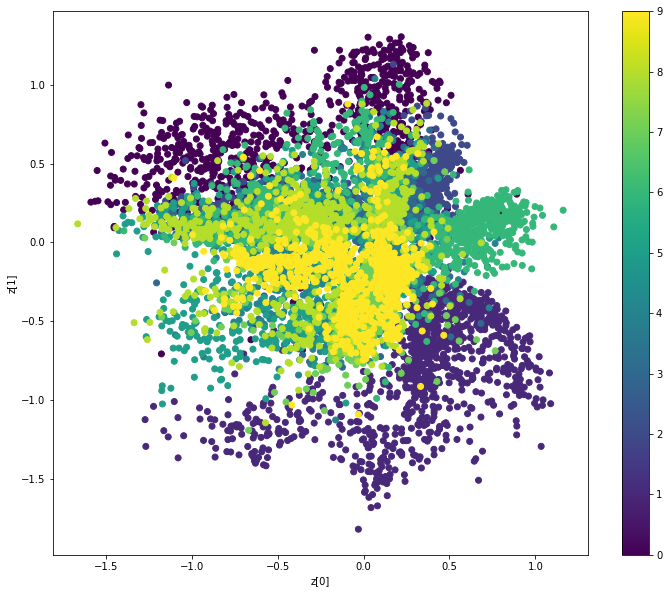

In [22]:
plot_results(models,
                 data,
                 batch_size=batch_size,
                 model_name="vae_mlp")

In [48]:
def plot_autoencoder_outputs(encoder, n, dims):
    #decoded_imgs = enconder.predict(x_test)
    #x_test_encoded = vae.predict(x_test, batch_size = batch_size)
    # number of example digits to show
    #n = 5
    j=8000
    plt.figure(figsize=(20, 5))
    for i in range(0, n):
        # plot original image
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[j].reshape(*dims))
        #plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n/2:
            ax.set_title('Original Images')

        # plot reconstruction 
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(x_test_encoded[j].reshape(*dims))
        #plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n/2:
            ax.set_title('Reconstructed Images')
        j=j+1
    plt.show()

In [49]:
x_test_encoded = vae.predict(x_test, batch_size = 80)

In [50]:
print(x_test_encoded[10])

[1.3819618e-10 2.4117364e-10 2.0444145e-10 ... 1.0803207e-02 1.5960104e-10
 1.4682834e-02]


In [51]:
np.shape(x_test_encoded)

(10000, 2312)

In [52]:
#x_test_encoded[x_test_encoded>0.35]=1
#x_test_encoded[x_test_encoded<-0.35]=-1
#x_test_encoded[abs(x_test_encoded)<=0.7]=0


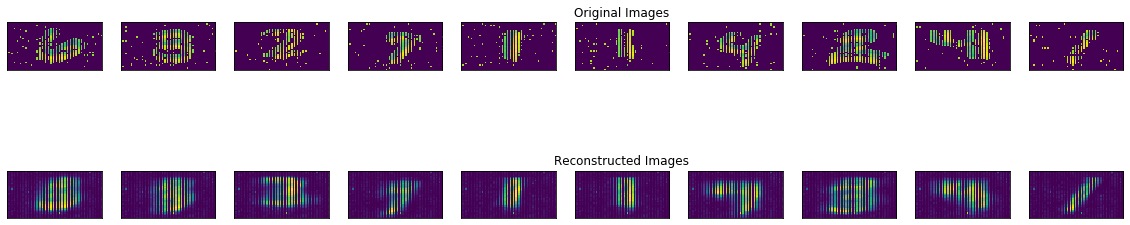

In [53]:
plot_autoencoder_outputs(x_test_encoded, 10, (34, 68))

In [54]:
vae_test.set_weights(vae.get_weights())

from random import shuffle

shuffle(x_test)

score = vae_test.evaluate(x_test, x_test, verbose=1, batch_size=80)
#score = vae.evaluate(x_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

10000/10000 [==============================] - 0s 26us/step
Test loss: 0.14153493773937226
Test accuracy: 0.8697523393630981
